# CEOS Data Cube - Fractional Coverage Analysis Notebook
<hr>
**Description:** This Python notebook calculates vegetation fractional cover using a Landsat-7 Data Cube. Vegetation fractional cover represents the exposed proportion of Photosynthetic Vegetation (PV), Non-Photosynthetic Vegetation (NPV) and Bare Soil (BS) within each pixel. This product is useful for natural resource management, modeling carbon dynamics and assessing land cover change in time series. Accurate estimation of fractional cover is especially important for monitoring and modeling savanna systems, subject to highly seasonal rainfall and drought, grazing by domestic and native animals, and frequent burning. 
<hr>
# Notebook Index

* [Import dependencies and connect to the datacube](#import)
* [Choose platform and product](#plat_prod)
* [Define extents you require that fall within the maximum extents](#define_extents) (selecting too much can make the acquisition process slow)
* [Understand filtering of cloud data and scan lines](#filter)
* [Retrieve the data from the datacube](#retrieve_data)
* [Obtain the clean mask](#obtain_clean_mask)
* [Filter out clouds and scan lines, and create a mosaic](#clean_mask_mosaic)
* [Run the fractional coverage algorithm](#fractional_coverage)
* [Plot the results](#plot)

## <a id="import">Import dependencies and connect to the Data Cube</a>

In [1]:
%matplotlib inline

from datetime import datetime
import numpy as np
import xarray as xr
import scipy.optimize as opt 
import matplotlib.pyplot as plt

import datacube
from utils.data_cube_utilities.data_access_api import DataAccessApi
import utils.data_cube_utilities.dc_utilities as utilities
from utils.data_cube_utilities.dc_mosaic import create_mean_mosaic
from utils.data_cube_utilities.clean_mask import landsat_qa_clean_mask

from dc_notebook_utilities import create_platform_product_gui, generate_metadata_report, create_extents_gui
import utils.data_cube_utilities.dc_fractional_coverage_classifier as frac_cov_cls
from utils.data_cube_utilities.dc_display_map import display_map

dc = datacube.Datacube(config='/home/localuser/.datacube.conf', app='dc-frac-cov-analysis')
api = DataAccessApi(config="/home/localuser/.datacube.conf")

## <a id="plat_prod">Choose platform and product</a>

In [2]:
# Get available products
products = dc.list_products()

#List the LANDSAT 7 products
print(products[["platform", "name"]][products.platform == "LANDSAT_7"])

     platform                           name
id                                          
8   LANDSAT_7       ls7_collections_sr_scene
70  LANDSAT_7  ls7_collections_sr_scene_lean
19  LANDSAT_7        ls7_ledaps_amazon_river
20  LANDSAT_7          ls7_ledaps_bangladesh
35  LANDSAT_7     ls7_ledaps_bangladesh_bari
36  LANDSAT_7             ls7_ledaps_caqueta
21  LANDSAT_7            ls7_ledaps_colombia
22  LANDSAT_7               ls7_ledaps_ghana
23  LANDSAT_7               ls7_ledaps_kenya
41  LANDSAT_7        ls7_ledaps_lake_baringo
24  LANDSAT_7      ls7_ledaps_lake_chad_full
25  LANDSAT_7        ls7_ledaps_lake_cortijo
26  LANDSAT_7      ls7_ledaps_menindee_lakes
27  LANDSAT_7          ls7_ledaps_meta_river
62  LANDSAT_7              ls7_ledaps_mexico
28  LANDSAT_7     ls7_ledaps_salgar_colombia
72  LANDSAT_7          ls7_ledaps_sanagustin
63  LANDSAT_7               ls7_ledaps_scene
29  LANDSAT_7                ls7_ledaps_togo
30  LANDSAT_7               ls7_ledaps_tonga
31  LANDSA

In [3]:
# These are the platform (satellite) and product (datacube set) 
# used for this demonstration.
platform = "LANDSAT_7"
product = "ls7_ledaps_colombia"

## <a id="extents">Get the Extents of the Cube</a>

In [4]:
# Get the extents of the cube.
descriptor = api.get_query_metadata(platform=platform, product=product)

# Store the latitudinal and longitudinal extents.
lat, lon = products.resolution[products.platform == platform].any()

In [5]:
from utils.data_cube_utilities.dc_display_map import display_map

#save extents
min_date, max_date = descriptor['time_extents']
min_lat, max_lat = descriptor['lat_extents']
min_lon, max_lon = descriptor['lon_extents']

#Adjust date string
min_date_str = str(min_date.year) + '-' + str(min_date.month) + '-' + str(min_date.day)
max_date_str = str(max_date.year) + '-' + str(max_date.month) + '-' + str(max_date.day)

#Round GPS coordinates to 3 decimal places
min_lat_rounded = round(min_lat, 3)
min_lon_rounded =  round(min_lon, 3)
max_lat_rounded = round(max_lat, 3)
max_lon_rounded = round(max_lon, 3)

#display the total area available in this datacube product that can be used for analysis
display_map(latitude = (min_lat_rounded, max_lat_rounded),longitude = (min_lon_rounded, max_lon_rounded))

In [6]:
# Display metadata.
generate_metadata_report(min_date_str, max_date_str, 
                         min_lon_rounded, max_lon_rounded, lon,
                         min_lat_rounded, max_lat_rounded, lat)

,Min,Max,Resolution
Date:,2000-1-3,2015-12-14,
Longitude:,-76.518,-74.046,0.000269995
Latitude:,-0.946,2.402,-0.000271302


## <a id="define_extents">Define the extents of the analysis</a>

In [7]:
# Specify latitude and longitude bounds within the full extents 
# shown in the metadata report above (reduce area for faster processing times).
min_lat_small = 0.9300
max_lat_small = 1.0443
min_lon_small = -74.7894
max_lon_small = -74.6679
lat_small = (min_lat_small, max_lat_small)
lon_small = (min_lon_small, max_lon_small)
display_map(lat_small, lon_small)

## <a id="filter">Filtering clouds and scan lines</a>

#### Clouds:
Clouds can obscure imagery from satellites making the analysis harder to perform.  Fortunately clouds can be filtered out rather easily using images from other dates close to the target date.  The small illustration below shows how clouds can obsure a satellite image:
  ![](diagrams/rainy_demo/cloud_clip_01.PNG)

#### Scan Lines:
Scan lines are an artifact of Landsat satellite imagery.  They are a result of a malfunction in the system responsible for ensuring full coverage.  As a result there are missing strips of imagery from most Landsat images.  The illsutration below shows what scan lines might look like on a satellite image:
![](diagrams/rainy_demo/slc_error_02.PNG)

## <a id="retrieve_data">Retrieve the data from the datacube</a>

In [8]:
from datetime import datetime as dt
start_date = dt.strptime('2010-01-01', '%Y-%m-%d')
end_date   = dt.strptime('2015-12-31', '%Y-%m-%d')
time_extents = (start_date, end_date)

In [9]:
# Query the Data Cube
dataset_in = dc.load(lat = (min_lat_small, max_lat_small),
                     lon = (min_lon_small, max_lon_small),
                     platform = platform,
                     time = time_extents,
                     product = product,
                     measurements=['red','green','blue','nir','swir1','swir2', 'pixel_qa'])

**At this point, we have finished accessing our data cube and we can turn to analyzing our data.** In this example, we will run the fractional coverage algorithm as presented in Guerschman.
*****
For more information on the fractional coverage algorithm, refer to:
Guerschman, Juan P., et al. (2015) "Assessing the effects of site heterogeneity and soil properties when unmixing photosynthetic vegetation, non-photosynthetic vegetation and bare soil fractions from Landsat and MODIS data." Remote Sensing of Environment 161: 12-26.
*****
**Create a cloudfree, mean pixel mosaic from the retrieved dataset.** The fractional coverage algorithm will then be applied to the mosaic.

## <a id="obtain_clean_mask">Obtain the clean mask</a>

In [11]:
clean_mask = landsat_qa_clean_mask(dataset_in, platform)

## <a id="clean_mask_mosaic">Filter out clouds and scan lines, and create a mosaic</a>

In [12]:
mosaic = create_mean_mosaic(dataset_in, clean_mask=clean_mask)

## <a id="fractional_coverage">Run the fractional coverage algorithm</a>

In [13]:
import importlib
importlib.reload(frac_cov_cls)
result = frac_cov_cls.frac_coverage_classify(mosaic, clean_mask=clean_mask)

## <a id="plot">Plot the results</a>

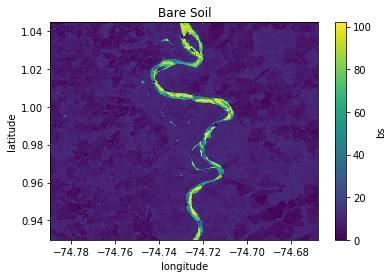

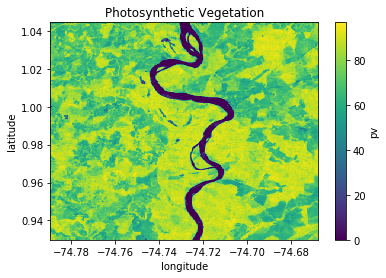

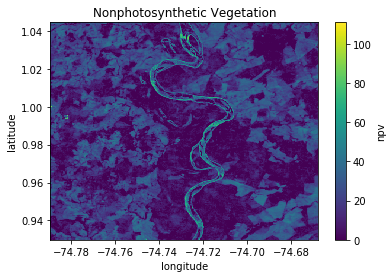

In [14]:
for data_var in result.data_vars:
    titles = {'bs': 'Bare Soil', 
              'pv': 'Photosynthetic Vegetation', 
              'npv': 'Nonphotosynthetic Vegetation'}
    result[data_var].plot()
    plt.title(titles[data_var])
    plt.show()